In [ ]:
pip install optuna

In [ ]:
pip install catboost

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import optuna
import catboost as ctb
from sklearn.metrics import confusion_matrix
import copy
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [6]:
df_orig=pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [7]:
df_orig['customerID'].duplicated().any() #all unique

False

In [8]:
df_orig.info() #no null/missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
replacing_values=['No phone service','No internet service']
for each in replacing_values:
  df_orig=df_orig.replace(to_replace=each,value='No')

# some missing values in total_charges---> filling them with zero
df_orig['TotalCharges']=df_orig['TotalCharges'].replace(to_replace=' ',value=0)
df_orig['TotalCharges']=df_orig['TotalCharges'].map(lambda x:float(x))

#replacing "Yes" and "No" with 1 and 0 respectively for target variable
df_orig['Churn']=df_orig['Churn'].replace(to_replace='Yes',value=1)
df_orig['Churn']=df_orig['Churn'].replace(to_replace='No',value=0)


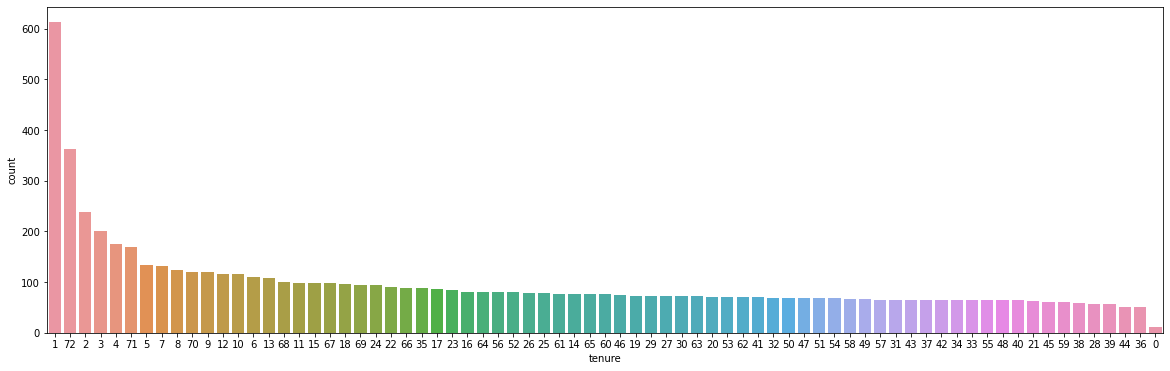

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(x=df_orig.columns[5],data=df_orig,order=df_orig[df_orig.columns[5]].value_counts().index)
plt.show()
#majority of people with 1 tenure

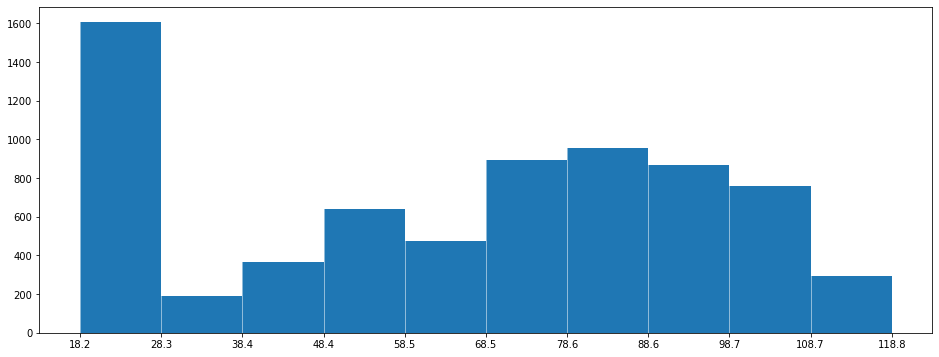

In [11]:
fig = plt.figure(figsize=(16,6))
n, bins, patches = plt.hist(df_orig.MonthlyCharges)
plt.xticks(bins)
plt.grid(color='white', lw = 0.5, axis='x')
plt.show()

## so maximum chrges are of around 20 

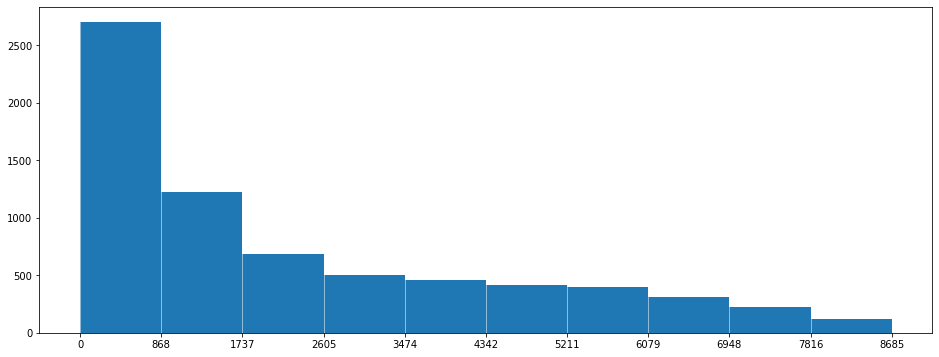

In [12]:
fig = plt.figure(figsize=(16,6))
n, bins, patches = plt.hist(df_orig.TotalCharges)
plt.xticks(bins)
plt.grid(color='white', lw = 0.5, axis='x')
plt.show()
## so maximum total chrges are of around 0-868

In [13]:
#Numerical columns are only three TotalCharges,MonthlyCharges,tenure others are categorical.

numerical_columns=['tenure','TotalCharges','MonthlyCharges']
target=['Churn']
other_info=['customerID']

In [14]:
for each in df_orig.columns:
  if each not in target and each not in numerical_columns and each not in other_info:
    print(each)
    print(df_orig[each].value_counts())
    print('-------------------------------------------------------------')

gender
Male      3555
Female    3488
Name: gender, dtype: int64
-------------------------------------------------------------
SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
-------------------------------------------------------------
Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
-------------------------------------------------------------
Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
-------------------------------------------------------------
PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
-------------------------------------------------------------
MultipleLines
No     4072
Yes    2971
Name: MultipleLines, dtype: int64
-------------------------------------------------------------
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
-------------------------------------------------------------
OnlineSecurity
No     5024
Yes    2019
Name: OnlineSec

In [15]:
'''
1. Almost same type of gender
2. Less senior citizens
3. Almost same number of customer between having partner/no partner
4. Majority of customers have dependents,have phone service,use fibre optic, are month-month,do paperlessbilling and prefer electronic check.
5. Majority of customers dont have online security,dont use multple lines,dont have backup,dont have device protection,
streamingtv,streamingmovies,techsupport

'''

'\n1. Almost same type of gender\n2. Less senior citizens\n3. Almost same number of customer between having partner/no partner\n4. Majority of customers have dependents,have phone service,use fibre optic, are month-month,do paperlessbilling and prefer electronic check.\n5. Majority of customers dont have online security,dont use multple lines,dont have backup,dont have device protection,\nstreamingtv,streamingmovies,techsupport\n\n'

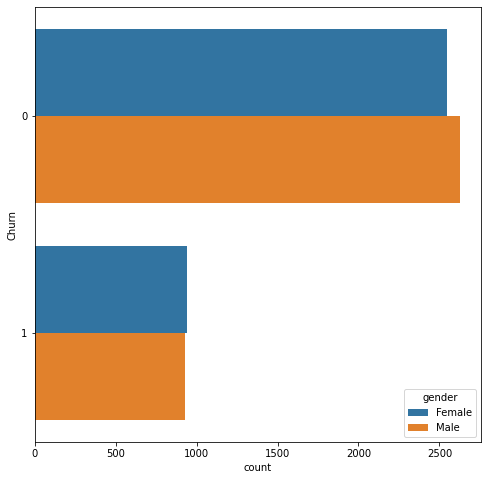

'\nmales and females are same in both, so it does not seems to drive churn rate but still lets make hypthosis that a\n'

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['gender'],y=df_orig['Churn'])
plt.show()

'''
males and females are same in both, so it does not seems to drive churn rate but still lets make hypthosis that a
'''

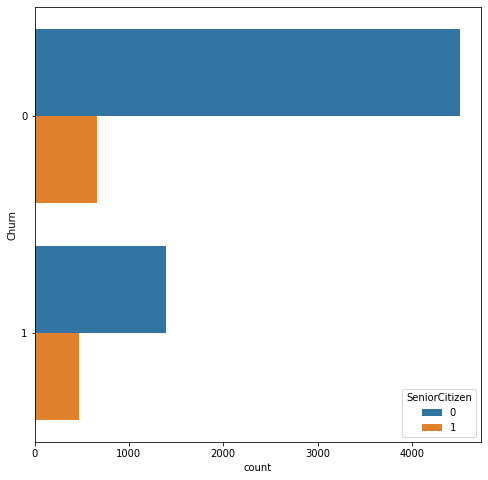

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['SeniorCitizen'],y=df_orig['Churn'])
plt.show()

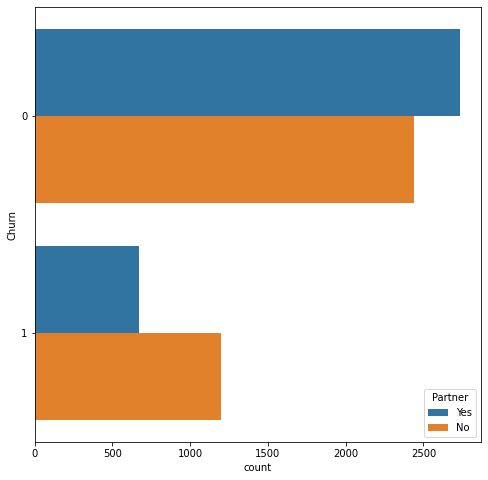

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['Partner'],y=df_orig['Churn'])
plt.show()
# this is intersting, amongst leaving customers, more no. of them don't have partners
#hypothesis:----- 

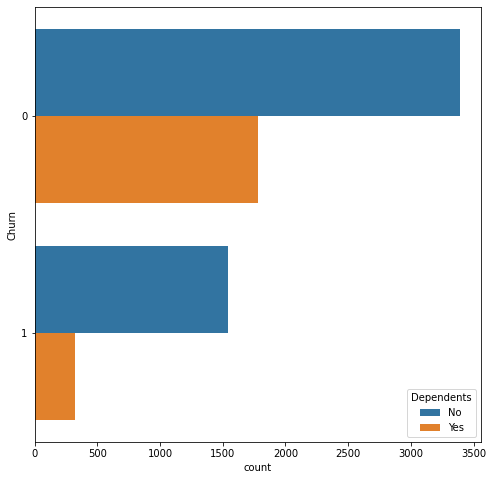

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['Dependents'],y=df_orig['Churn'])
plt.show()

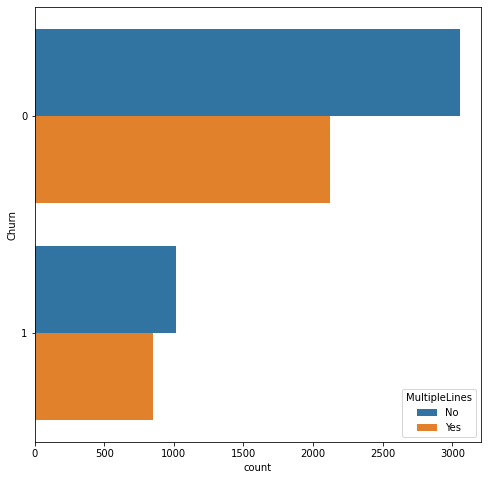

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['MultipleLines'],y=df_orig['Churn'])
plt.show()
# can try here

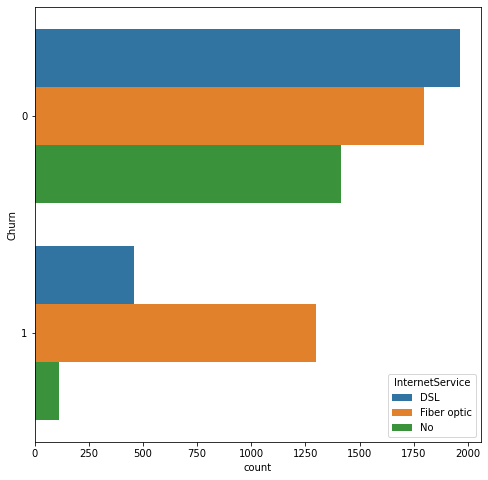

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['InternetService'],y=df_orig['Churn'])
plt.show()
# leaving customers prefered fibre optic as compared to others

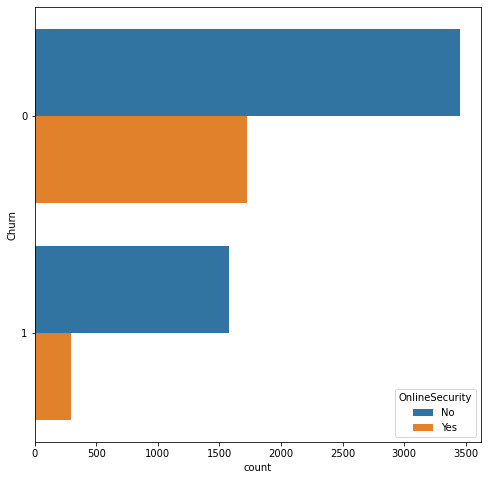

In [22]:

fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['OnlineSecurity'],y=df_orig['Churn'])
plt.show()

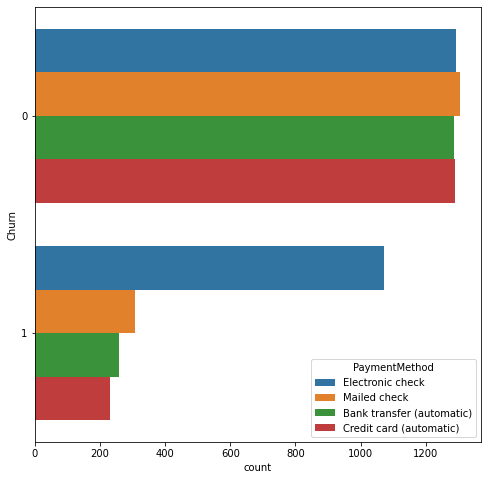

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['PaymentMethod'],y=df_orig['Churn'])
plt.show()
# leaving customer left because they had to use electronic check as retained customers have equal mode of payment type 

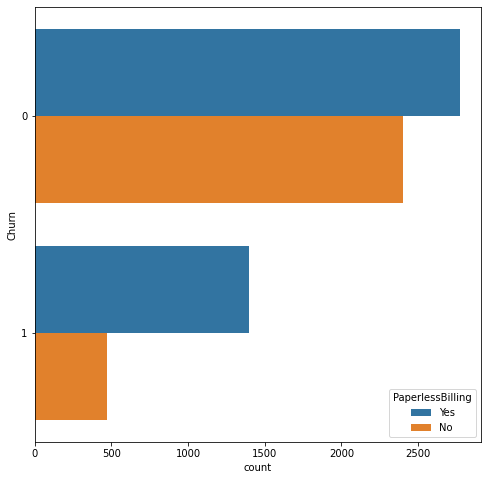

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['PaperlessBilling'],y=df_orig['Churn'])
plt.show()


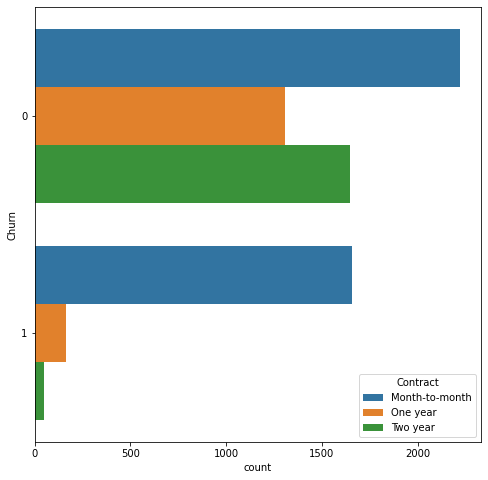

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(hue=df_orig['Contract'],y=df_orig['Churn'])
plt.show()
#so, maximum of left customers were month-to-month

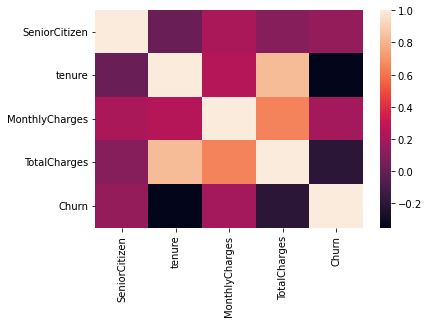

In [26]:
sns.heatmap(df_orig.corr())
plt.show()
#higher total_charges customers have low churn rate

In [27]:
df_orig.corr()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.103006,0.150889
tenure,0.016567,1.000000,0.247900,0.826178,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.651174,0.193356
TotalCharges,0.103006,0.826178,0.651174,1.000000,-0.198324
Churn,0.150889,-0.352229,0.193356,-0.198324,1.000000


In [28]:
#catboost baseline without hyperparameter tuning

In [29]:
class catboost_baseline():
  def __init__(self,original_dataframe):
    self.original_dataframe=original_dataframe
    print("Warming up...Processing the Dataset!")
    self.dataset_modification()
    print("Hold on...Building Catboost Baseline Model!")
    self.model()
    print("Wait...Preparing reports! ")
    self.reports()
    print("All Done!")

  def dataset_modification(self):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.original_dataframe, self.original_dataframe.Churn, test_size=0.33, random_state=42,stratify=self.original_dataframe.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1

    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def model(self):
    scores=[]
    final_test_predictions = []
    final_valid_predictions = {}
    for fold in range(5):
      xtrain =  self.X_train[self.X_train.kfold != fold].reset_index(drop=True)
      xvalid = self.X_train[self.X_train.kfold == fold].reset_index(drop=True)
      xtest = self.X_test.copy()
      valid_ids = xvalid.customerID.values.tolist()
      
      ytrain = xtrain.Churn
      yvalid = xvalid.Churn
      
      xtrain = xtrain[self.useful_features]
      xvalid = xvalid[self.useful_features]
      scaler = StandardScaler()
      xtrain[self.numerical_columns] = scaler.fit_transform(xtrain[self.numerical_columns])
      xvalid[self.numerical_columns] = scaler.transform(xvalid[self.numerical_columns])
      xtest[self.numerical_columns] = scaler.transform(xtest[self.numerical_columns])
      
      model = ctb.CatBoostClassifier(iterations=1000, random_state=22,cat_features=self.categorical_columns,verbose=0)
      model.fit(xtrain, ytrain)
      preds_valid = model.predict(xvalid[self.useful_features])
      test_preds = model.predict(xtest[self.useful_features])
      final_test_predictions.append(test_preds)
      final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
      scores.append(metrics.recall_score(yvalid, preds_valid))
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ["customerID", "pred_1"]
    preds = np.max(np.column_stack(final_test_predictions), axis=1)
    self.pred_df=pd.DataFrame(preds)
    self.pred_df.columns=['pred_catboost_baseline']

    return self.pred_df

  def reports(self):
    self.temp_report=classification_report(self.test_labels,self.pred_df)
    return self.temp_report



In [30]:
cat_temp=catboost_baseline(df_orig)

Warming up...Processing the Dataset!
Hold on...Building Catboost Baseline Model!
Wait...Preparing reports! 
All Done!


In [31]:
print(cat_temp.reports())

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1708
           1       0.62      0.61      0.62       617

    accuracy                           0.80      2325
   macro avg       0.74      0.74      0.74      2325
weighted avg       0.80      0.80      0.80      2325



In [24]:
#xgboost baseline

In [25]:
class xgboost_baseline():
  def __init__(self,original_dataframe):
    self.original_dataframe=original_dataframe
    self.df_new=copy.deepcopy(original_dataframe)
    print("Warming up...Processing the Dataset!")
    self.dataset_modification()
    print("Hold on...Building XGBOOST baseline Model!")
    self.model()
    print("Wait...Preparing reports! ")
    self.reports()
    print("All Done!")

  def dataset_modification(self):
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        self.df_new = pd.concat([self.df_new, dummies], axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.df_new, self.df_new.Churn, test_size=0.33, random_state=42,stratify=self.df_new.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1

    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def model(self):
    scores=[]
    final_test_predictions = []
    final_valid_predictions = {}
    for fold in range(5):
      xtrain =  self.X_train[self.X_train.kfold != fold].reset_index(drop=True)
      xvalid = self.X_train[self.X_train.kfold == fold].reset_index(drop=True)
      xtest = self.X_test.copy()
      valid_ids = xvalid.customerID.values.tolist()
      
      ytrain = xtrain.Churn
      yvalid = xvalid.Churn
      
      xtrain = xtrain[self.useful_features]
      xvalid = xvalid[self.useful_features]
      scaler = StandardScaler()
      xtrain[self.numerical_columns] = scaler.fit_transform(xtrain[self.numerical_columns])
      xvalid[self.numerical_columns] = scaler.transform(xvalid[self.numerical_columns])
      xtest[self.numerical_columns] = scaler.transform(xtest[self.numerical_columns])
      
      model = XGBClassifier(random_state=42,n_estimators=1000)
      model.fit(xtrain, ytrain)
      preds_valid = model.predict(xvalid[self.useful_features])
      test_preds = model.predict(xtest[self.useful_features])
      final_test_predictions.append(test_preds)
      final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
      scores.append(metrics.recall_score(yvalid, preds_valid))
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ["customerID", "pred_1"]
    preds = np.max(np.column_stack(final_test_predictions), axis=1)
    self.pred_df=pd.DataFrame(preds)
    self.pred_df.columns=['pred_catboost_baseline']

    return self.pred_df

  def reports(self):
    self.temp_report=classification_report(self.test_labels,self.pred_df)
    return self.temp_report



In [26]:
xg_temp=xgboost_baseline(df_orig)

Warming up...Processing the Dataset!
Hold on...Building the Model!
Wait...Preparing reports! 
All Done!


In [27]:
print(xg_temp.reports())

              precision    recall  f1-score   support

           0       0.87      0.81      0.83      1708
           1       0.55      0.66      0.60       617

    accuracy                           0.77      2325
   macro avg       0.71      0.73      0.72      2325
weighted avg       0.78      0.77      0.77      2325



In [ ]:
#adaboost baseline


In [36]:
class adaboost_baseline():
  def __init__(self,original_dataframe):
    self.original_dataframe=original_dataframe
    self.df_new=copy.deepcopy(original_dataframe)
    print("Warming up...Processing the Dataset!")
    self.dataset_modification()
    print("Hold on...Building ADABOOST baseline Model!")
    self.model()
    print("Wait...Preparing reports! ")
    self.reports()
    print("All Done!")

  def dataset_modification(self):
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        self.df_new = pd.concat([self.df_new, dummies], axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.df_new, self.df_new.Churn, test_size=0.33, random_state=42,stratify=self.df_new.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1

    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def model(self):
    scores=[]
    final_test_predictions = []
    final_valid_predictions = {}
    for fold in range(5):
      xtrain =  self.X_train[self.X_train.kfold != fold].reset_index(drop=True)
      xvalid = self.X_train[self.X_train.kfold == fold].reset_index(drop=True)
      xtest = self.X_test.copy()
      valid_ids = xvalid.customerID.values.tolist()
      
      ytrain = xtrain.Churn
      yvalid = xvalid.Churn
      
      xtrain = xtrain[self.useful_features]
      xvalid = xvalid[self.useful_features]
      scaler = StandardScaler()
      xtrain[self.numerical_columns] = scaler.fit_transform(xtrain[self.numerical_columns])
      xvalid[self.numerical_columns] = scaler.transform(xvalid[self.numerical_columns])
      xtest[self.numerical_columns] = scaler.transform(xtest[self.numerical_columns])
      
      model = AdaBoostClassifier(random_state=fold,n_estimators=1000)
      model.fit(xtrain, ytrain)
      preds_valid = model.predict(xvalid[self.useful_features])
      test_preds = model.predict(xtest[self.useful_features])
      final_test_predictions.append(test_preds)
      final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
      scores.append(metrics.recall_score(yvalid, preds_valid))
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ["customerID", "pred_1"]
    preds = np.max(np.column_stack(final_test_predictions), axis=1)
    self.pred_df=pd.DataFrame(preds)
    self.pred_df.columns=['pred_catboost_baseline']

    return self.pred_df

  def reports(self):
    self.temp_report=classification_report(self.test_labels,self.pred_df)
    return self.temp_report



In [37]:
ab_temp=adaboost_baseline(df_orig)

Warming up...Processing the Dataset!
Hold on...Building ADABOOST baseline Model!
Wait...Preparing reports! 
All Done!


In [38]:
print(ab_temp.reports())

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1708
           1       0.58      0.66      0.62       617

    accuracy                           0.79      2325
   macro avg       0.73      0.75      0.74      2325
weighted avg       0.80      0.79      0.79      2325



In [39]:
#Polyfeaures (Feature Engineering)

In [69]:
class adaboost_polyfeatures():
  def __init__(self,original_dataframe):
    self.original_dataframe=original_dataframe
    self.df_new=copy.deepcopy(original_dataframe)
    print("Warming up...Processing the Dataset!")
    print("Calculating New Features!")
    self.dataset_modification()
    print("Hold on...Building ADABOOST Feature Engineered Model!")
    self.model()
    print("Wait...Preparing reports! ")
    self.reports()
    print("All Done!")

  def dataset_modification(self):
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        self.df_new = pd.concat([self.df_new, dummies], axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)
    
    
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_dataframe=poly.fit_transform(self.df_new[self.numerical_columns])
    self.df_poly = pd.DataFrame(poly_dataframe, columns=[f"poly_{self.df_new.columns[i]}_{i}" for i in range(poly_dataframe.shape[1])])

    self.df = pd.concat([self.df_new, self.df_poly], axis=1)

    self.df_new=self.df
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.df_new, self.df_new.Churn, test_size=0.33, random_state=42,stratify=self.df_new.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1
    self.useful_features = [c for c in self.df_new.columns if c not in ("customerID", "Churn", "kfold")]
    self.X_test = self.X_test[self.useful_features]
    
    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]
    
    
    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def model(self):
    scores=[]
    final_test_predictions = []
    final_valid_predictions = {}
    for fold in range(5):
      xtrain =  self.X_train[self.X_train.kfold != fold].reset_index(drop=True)
      xvalid = self.X_train[self.X_train.kfold == fold].reset_index(drop=True)
      xtest = self.X_test.copy()
      valid_ids = xvalid.customerID.values.tolist()
      
      ytrain = xtrain.Churn
      yvalid = xvalid.Churn
      
      xtrain = xtrain[self.useful_features]
      xvalid = xvalid[self.useful_features]
      scaler = StandardScaler()
      xtrain[self.numerical_columns] = scaler.fit_transform(xtrain[self.numerical_columns])
      xvalid[self.numerical_columns] = scaler.transform(xvalid[self.numerical_columns])
      xtest[self.numerical_columns] = scaler.transform(xtest[self.numerical_columns])
      
      model = AdaBoostClassifier(random_state=fold,n_estimators=1000)
      model.fit(xtrain, ytrain)
      preds_valid = model.predict(xvalid[self.useful_features])
      test_preds = model.predict(xtest[self.useful_features])
      final_test_predictions.append(test_preds)
      final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
      scores.append(metrics.recall_score(yvalid, preds_valid))
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ["customerID", "pred_1"]
    preds = np.max(np.column_stack(final_test_predictions), axis=1)
    self.pred_df=pd.DataFrame(preds)
    self.pred_df.columns=['pred_catboost_baseline']

    return self.pred_df

  def reports(self):
    self.temp_report=classification_report(self.test_labels,self.pred_df)
    return self.temp_report



In [70]:
ab_poly=adaboost_polyfeatures(df_orig)

Warming up...Processing the Dataset!
Calculating New Features!
Hold on...Building ADABOOST Feature Engineered Model!
Wait...Preparing reports! 
All Done!


In [71]:
print(ab_poly.reports())

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1708
           1       0.59      0.65      0.62       617

    accuracy                           0.79      2325
   macro avg       0.73      0.74      0.73      2325
weighted avg       0.79      0.79      0.79      2325



In [79]:
class xgboost_polyfeatures():
  def __init__(self,original_dataframe):
    self.original_dataframe=original_dataframe
    self.df_new=copy.deepcopy(original_dataframe)
    print("Warming up...Processing the Dataset!")
    print("Calculating New Features!")
    self.dataset_modification()
    print("Hold on...Building XGBoost Feature Engineered Model!")
    self.model()
    print("Wait...Preparing reports! ")
    self.reports()
    print("All Done!")

  def dataset_modification(self):
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        self.df_new = pd.concat([self.df_new, dummies], axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)
    
    
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_dataframe=poly.fit_transform(self.df_new[self.numerical_columns])
    self.df_poly = pd.DataFrame(poly_dataframe, columns=[f"poly_{self.df_new.columns[i]}_{i}" for i in range(poly_dataframe.shape[1])])

    self.df = pd.concat([self.df_new, self.df_poly], axis=1)

    self.df_new=self.df
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.df_new, self.df_new.Churn, test_size=0.33, random_state=42,stratify=self.df_new.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1
    self.useful_features = [c for c in self.df_new.columns if c not in ("customerID", "Churn", "kfold")]
    self.X_test = self.X_test[self.useful_features]
    
    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]
    
    
    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def model(self):
    scores=[]
    final_test_predictions = []
    final_valid_predictions = {}
    for fold in range(5):
      xtrain =  self.X_train[self.X_train.kfold != fold].reset_index(drop=True)
      xvalid = self.X_train[self.X_train.kfold == fold].reset_index(drop=True)
      xtest = self.X_test.copy()
      valid_ids = xvalid.customerID.values.tolist()
      
      ytrain = xtrain.Churn
      yvalid = xvalid.Churn
      
      xtrain = xtrain[self.useful_features]
      xvalid = xvalid[self.useful_features]
      scaler = StandardScaler()
      xtrain[self.numerical_columns] = scaler.fit_transform(xtrain[self.numerical_columns])
      xvalid[self.numerical_columns] = scaler.transform(xvalid[self.numerical_columns])
      xtest[self.numerical_columns] = scaler.transform(xtest[self.numerical_columns])
      
      model = XGBClassifier(random_state=42,n_estimators=1000)
      model.fit(xtrain, ytrain)
      preds_valid = model.predict(xvalid[self.useful_features])
      test_preds = model.predict(xtest[self.useful_features])
      final_test_predictions.append(test_preds)
      final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
      scores.append(metrics.recall_score(yvalid, preds_valid))
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ["customerID", "pred_1"]
    preds = np.max(np.column_stack(final_test_predictions), axis=1)
    self.pred_df=pd.DataFrame(preds)
    self.pred_df.columns=['pred_catboost_baseline']

    return self.pred_df

  def reports(self):
    self.temp_report=classification_report(self.test_labels,self.pred_df)
    return self.temp_report



In [80]:
xg_poly=xgboost_polyfeatures(df_orig)

Warming up...Processing the Dataset!
Calculating New Features!
Hold on...Building ADABOOST Feature Engineered Model!
Wait...Preparing reports! 
All Done!


In [81]:
print(xg_poly.reports())
#better than adaboost

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1708
           1       0.54      0.67      0.60       617

    accuracy                           0.76      2325
   macro avg       0.71      0.73      0.71      2325
weighted avg       0.78      0.76      0.77      2325



In [131]:
##feature selection

In [73]:
class adaboost_polyfeatures_feature_selection():
  def __init__(self,original_dataframe):
    self.original_dataframe=original_dataframe
    self.df_new=copy.deepcopy(original_dataframe)
    print("Warming up...Processing the Dataset!")
    print("Calculating New Features and Performing Feature Selection!")
    self.dataset_modification()
    print("Hold on...Building ADABOOST with Feature Engineering and Feature Selection Model !")
    self.model()
    print("Wait...Preparing reports! ")
    self.reports()
    print("All Done!")

  def dataset_modification(self):
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        self.df_new = pd.concat([self.df_new, dummies], axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)
    
    
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_dataframe=poly.fit_transform(self.df_new[self.numerical_columns])
    self.df_poly = pd.DataFrame(poly_dataframe, columns=[f"poly_{self.df_new.columns[i]}_{i}" for i in range(poly_dataframe.shape[1])])

    self.df = pd.concat([self.df_new, self.df_poly], axis=1)

    self.df_new=self.df

    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]
    self.temp_df=self.df_new[self.useful_features]
    self.temp_y=pd.Series(self.df_new.Churn)
    sfs = SFS(RandomForestClassifier(random_state=0,n_jobs=-1), n_features_to_select=6)
    
    sfs.fit(self.temp_df,self.temp_y.ravel())
    self.new_df=sfs.transform(self.temp_df)
    self.new_df=pd.DataFrame(self.new_df)
    self.new_df.columns=sfs.get_feature_names_out()

    #self.df_new=self.new_df
    for each in self.df_new.columns:
      if each not in ("Churn", "customerID", "kfold"):
        if each not in self.new_df.columns:
          self.df_new.drop([each],axis=1,inplace=True)

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.df_new, self.df_new.Churn, test_size=0.33, random_state=42,stratify=self.df_new.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1
    self.useful_features = [c for c in self.df_new.columns if c not in ("customerID", "Churn", "kfold")]
    self.X_test = self.X_test[self.useful_features]
    
    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]
    
    #self.X_train=self.df
    #self.X_test=self.df_test
    
    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def model(self):
    scores=[]
    final_test_predictions = []
    final_valid_predictions = {}
    for fold in range(5):
      xtrain =  self.X_train[self.X_train.kfold != fold].reset_index(drop=True)
      xvalid = self.X_train[self.X_train.kfold == fold].reset_index(drop=True)
      xtest = self.X_test.copy()
      valid_ids = xvalid.customerID.values.tolist()
      
      ytrain = xtrain.Churn
      yvalid = xvalid.Churn
      
      xtrain = xtrain[self.useful_features]
      xvalid = xvalid[self.useful_features]
      scaler = StandardScaler()
      xtrain[self.useful_features] = scaler.fit_transform(xtrain[self.useful_features])
      xvalid[self.useful_features] = scaler.transform(xvalid[self.useful_features])
      xtest[self.useful_features] = scaler.transform(xtest[self.useful_features])
      
      model = AdaBoostClassifier(random_state=fold,n_estimators=1000)
      model.fit(xtrain, ytrain)
      preds_valid = model.predict(xvalid[self.useful_features])
      test_preds = model.predict(xtest[self.useful_features])
      final_test_predictions.append(test_preds)
      final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
      scores.append(metrics.recall_score(yvalid, preds_valid))
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ["customerID", "pred_1"]
    preds = np.max(np.column_stack(final_test_predictions), axis=1)
    self.pred_df=pd.DataFrame(preds)
    self.pred_df.columns=['pred_catboost_baseline']

    return self.pred_df

  def reports(self):
    self.temp_report=classification_report(self.test_labels,self.pred_df)
    return self.temp_report



In [61]:
ab_poly_fs=adaboost_polyfeatures_feature_selection(df_orig)

Warming up...Processing the Dataset!
Calculating New Features and Performing Feature Selection!
Hold on...Building ADABOOST with Feature Engineering and Feature Selection Model !
Wait...Preparing reports! 
All Done!


In [75]:
print(ab_poly_fs.reports())
#6 features combination reduces recall considerably

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1708
           1       0.63      0.53      0.57       617

    accuracy                           0.79      2325
   macro avg       0.73      0.71      0.72      2325
weighted avg       0.78      0.79      0.78      2325



In [82]:
class xgboost_polyfeatures_feature_selection():
  def __init__(self,original_dataframe):
    self.original_dataframe=original_dataframe
    self.df_new=copy.deepcopy(original_dataframe)
    print("Warming up...Processing the Dataset!")
    print("Calculating New Features and Performing Feature Selection!")
    self.dataset_modification()
    print("Hold on...Building XGBoost with Feature Engineering and Feature Selection Model !")
    self.model()
    print("Wait...Preparing reports! ")
    self.reports()
    print("All Done!")

  def dataset_modification(self):
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        self.df_new = pd.concat([self.df_new, dummies], axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)
    
    
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_dataframe=poly.fit_transform(self.df_new[self.numerical_columns])
    self.df_poly = pd.DataFrame(poly_dataframe, columns=[f"poly_{self.df_new.columns[i]}_{i}" for i in range(poly_dataframe.shape[1])])

    self.df = pd.concat([self.df_new, self.df_poly], axis=1)

    self.df_new=self.df

    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]
    self.temp_df=self.df_new[self.useful_features]
    self.temp_y=pd.Series(self.df_new.Churn)
    sfs = SFS(RandomForestClassifier(random_state=0,n_jobs=-1), n_features_to_select=6)
    
    sfs.fit(self.temp_df,self.temp_y.ravel())
    self.new_df=sfs.transform(self.temp_df)
    self.new_df=pd.DataFrame(self.new_df)
    self.new_df.columns=sfs.get_feature_names_out()

    #self.df_new=self.new_df
    for each in self.df_new.columns:
      if each not in ("Churn", "customerID", "kfold"):
        if each not in self.new_df.columns:
          self.df_new.drop([each],axis=1,inplace=True)

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.df_new, self.df_new.Churn, test_size=0.33, random_state=42,stratify=self.df_new.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1
    self.useful_features = [c for c in self.df_new.columns if c not in ("customerID", "Churn", "kfold")]
    self.X_test = self.X_test[self.useful_features]
    
    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]
    
        
    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def model(self):
    scores=[]
    final_test_predictions = []
    final_valid_predictions = {}
    for fold in range(5):
      xtrain =  self.X_train[self.X_train.kfold != fold].reset_index(drop=True)
      xvalid = self.X_train[self.X_train.kfold == fold].reset_index(drop=True)
      xtest = self.X_test.copy()
      valid_ids = xvalid.customerID.values.tolist()
      
      ytrain = xtrain.Churn
      yvalid = xvalid.Churn
      
      xtrain = xtrain[self.useful_features]
      xvalid = xvalid[self.useful_features]
      scaler = StandardScaler()
      xtrain[self.useful_features] = scaler.fit_transform(xtrain[self.useful_features])
      xvalid[self.useful_features] = scaler.transform(xvalid[self.useful_features])
      xtest[self.useful_features] = scaler.transform(xtest[self.useful_features])
      
      model = XGBClassifier(random_state=42,n_estimators=1000)
      model.fit(xtrain, ytrain)
      preds_valid = model.predict(xvalid[self.useful_features])
      test_preds = model.predict(xtest[self.useful_features])
      final_test_predictions.append(test_preds)
      final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
      scores.append(metrics.recall_score(yvalid, preds_valid))
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ["customerID", "pred_1"]
    preds = np.max(np.column_stack(final_test_predictions), axis=1)
    self.pred_df=pd.DataFrame(preds)
    self.pred_df.columns=['pred_catboost_baseline']

    return self.pred_df

  def reports(self):
    self.temp_report=classification_report(self.test_labels,self.pred_df)
    return self.temp_report



In [83]:
xg_poly_fs=xgboost_polyfeatures_feature_selection(df_orig)

Warming up...Processing the Dataset!
Calculating New Features and Performing Feature Selection!
Hold on...Building XGBoost with Feature Engineering and Feature Selection Model !
Wait...Preparing reports! 
All Done!


In [84]:
print(xg_poly_fs.reports()) 
#6 features reduced recall score considerably

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1708
           1       0.57      0.54      0.56       617

    accuracy                           0.77      2325
   macro avg       0.70      0.70      0.70      2325
weighted avg       0.77      0.77      0.77      2325



In [ ]:
#dataset for hyperparameer tuning
  

In [99]:

# Hyperparamater tuning using optuna

class hyperparameter_tuning_dataset():
  def __init__(self,original_dataframe):
    self.original_dataframe=original_dataframe
    self.df_new=copy.deepcopy(original_dataframe)
    print("Warming up...Processing the Dataset!")
    print("Calculating New Features!")
    self.dataset_modification()
    
   

  def dataset_modification(self):
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        self.df_new = pd.concat([self.df_new, dummies], axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)
    
    
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_dataframe=poly.fit_transform(self.df_new[self.numerical_columns])
    self.df_poly = pd.DataFrame(poly_dataframe, columns=[f"poly_{self.df_new.columns[i]}_{i}" for i in range(poly_dataframe.shape[1])])

    self.df = pd.concat([self.df_new, self.df_poly], axis=1)

    self.df_new=self.df
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.df_new, self.df_new.Churn, test_size=0.33, random_state=42,stratify=self.df_new.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1
    self.useful_features = [c for c in self.df_new.columns if c not in ("customerID", "Churn", "kfold")]
    self.X_test = self.X_test[self.useful_features]
    
    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]
    
    
    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train
  
 

In [116]:
def run(trial):
      
  fold = 0
  learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.5, log=True)
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
  subsample = trial.suggest_float("subsample", 0.1, 1.0)
  colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1)
  max_depth = trial.suggest_int("max_depth", 1, 10)
  colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.1, 1)
  colsample_bynode = trial.suggest_float("colsample_bynode", 0.1, 1)
  n_estimators=trial.suggest_int("n_estimators", 50, 15000)
  
  xtrain = training_dataset[training_dataset.kfold != fold].reset_index(drop=True)
  xvalid = training_dataset[training_dataset.kfold == fold].reset_index(drop=True)

  ytrain = xtrain.Churn
  yvalid = xvalid.Churn

  xtrain = xtrain[features_for_tuning]
  xvalid = xvalid[features_for_tuning]

  model = XGBClassifier(
      random_state=42,
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      reg_lambda=reg_lambda,
      reg_alpha=reg_alpha,
      subsample=subsample,
      colsample_bytree=colsample_bytree,
      colsample_bylevel=colsample_bylevel,
      colsample_bynode=colsample_bynode,
      max_depth=max_depth   )
  
  model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=1000)
  preds_valid = model.predict(xvalid)
  final_recall = metrics.recall_score(yvalid, preds_valid)
  return final_recall

In [117]:
data=hyperparameter_tuning_dataset(df_orig)


Warming up...Processing the Dataset!
Calculating New Features!


In [ ]:
study = optuna.create_study(direction="maximize")
training_dataset=data.X_train
features_for_tuning = [c for c in training_dataset.columns if c not in ("Churn", "customerID", "kfold")]
study.optimize(run, n_trials=1000)

In [119]:
study.best_params

{'learning_rate': 0.32484263976862376,
 'reg_lambda': 1.401665881183768e-07,
 'reg_alpha': 0.01848532454171293,
 'subsample': 0.13214961459779948,
 'colsample_bytree': 0.567968742389969,
 'max_depth': 2,
 'colsample_bylevel': 0.7475620170284228,
 'colsample_bynode': 0.7280304861776783,
 'n_estimators': 10414}

In [ ]:
'''
Following are the parameters obtained after hyperparamer tuning for XGBboost:-

{'learning_rate': 0.25689951598766714, 'reg_lambda': 0.0014202435426024106, 'reg_alpha': 7.795086291442854e-06, 
'subsample': 0.8475484420007269, 'colsample_bytree': 0.3768388422795381, 'max_depth': 3, 
'colsample_bylevel': 0.5010279139926787, 'colsample_bynode': 0.5388700791037054, 'n_estimators': 5345}

{'learning_rate': 0.32484263976862376,
 'reg_lambda': 1.401665881183768e-07,
 'reg_alpha': 0.01848532454171293,
 'subsample': 0.13214961459779948,
 'colsample_bytree': 0.567968742389969,
 'max_depth': 2,
 'colsample_bylevel': 0.7475620170284228,
 'colsample_bynode': 0.7280304861776783,
 'n_estimators': 10414}

'''

21

In [185]:
class xgboost_poly_tuned():
  def __init__(self,original_dataframe,test_dataset):
    self.test_dataset=test_dataset

    if isinstance(self.test_dataset, pd.DataFrame) :
      self.original_dataframe=original_dataframe
      self.df_new=copy.deepcopy(original_dataframe)
      print("Warming up...Processing the Dataset!")
      print("Calculating New Features!")
      self.dataset_modification_new_testdataset()
      print("Hold on...Building XGBoost Feature Engineered Model!")
      self.model()
      print("Wait...Preparing reports! ")
      self.reports()
      print("All Done!")
    else:
      self.original_dataframe=original_dataframe
      self.df_new=copy.deepcopy(original_dataframe)
      print("Warming up...Processing the Dataset!")
      print("Calculating New Features!")
      self.dataset_modification()
      print("Hold on...Building XGBoost Feature Engineered Model!")
      self.model()
      print("Wait...Preparing reports! ")
      self.reports()
      print("All Done!")


  def dataset_modification_new_testdataset(self):
    for each in self.test_dataset.columns:
      if each not in self.df_new.columns:
        self.test_dataset.drop([each],axis=1,inplace=True)
    
    for each in self.df_new.columns:
      if each not in self.test_dataset.columns:
        raise Exception(each+' not present in your Test Dataset')
      
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        dummies_test = pd.get_dummies(pd.Series(self.test_dataset[col]),prefix=col)

        self.df_new = pd.concat([self.df_new, dummies], axis=1)
        self.df_test_new=pd.concat([self.test_dataset,dummies_test],axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
                      'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
                      'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                      'PaymentMethod'],axis=1,inplace=True)
    self.df_test_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)
    
    
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_dataframe=poly.fit_transform(self.df_new[self.numerical_columns])
    poly_test_dataset=poly.fit_transform(self.df_test_new[self.numerical_columns])

    
    self.df_poly = pd.DataFrame(poly_dataframe, columns=[f"poly_{self.df_new.columns[i]}_{i}" for i in range(poly_dataframe.shape[1])])
    self.df_poly_test = pd.DataFrame(poly_test_dataset, columns=[f"poly_{self.df_test_new.columns[i]}_{i}" for i in range(poly_test_dataset.shape[1])])

    self.df = pd.concat([self.df_new, self.df_poly], axis=1)
    self.test_df=pd.concat([self.df_test_new, self.df_poly_test], axis=1)

    
    self.X_train= self.df
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_train= self.test_df
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    self.X_train["kfold"] = -1
    self.useful_features = [c for c in self.df_poly.columns if c not in ("customerID", "Churn", "kfold")]
    self.X_test = self.X_test[self.useful_features]


    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]
    
    
    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def dataset_modification(self):
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.df_new.columns if c not in ("Churn", "customerID", "kfold")]

    self.categorical_columns=[]
    for each in self.df_new.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)

    for col in self.categorical_columns:
        dummies = pd.get_dummies(pd.Series(self.df_new[col]),prefix=col)
        self.df_new = pd.concat([self.df_new, dummies], axis=1)
    self.df_new.drop(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],axis=1,inplace=True)
    
    
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_dataframe=poly.fit_transform(self.df_new[self.numerical_columns])
   
    self.df_poly = pd.DataFrame(poly_dataframe, columns=[f"poly_{self.df_new.columns[i]}_{i}" for i in range(poly_dataframe.shape[1])])

    self.df = pd.concat([self.df_new, self.df_poly], axis=1)

    self.df_new=self.df
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( 
        self.df_new, self.df_new.Churn, test_size=0.33, random_state=42,stratify=self.df_new.Churn)
    self.X_train.reset_index(drop=True,inplace=True)
    self.train_labels=self.X_train['Churn']
    self.X_test.reset_index(drop=True,inplace=True)
    self.test_labels=self.X_test['Churn']
    del self.y_train,self.y_test
    self.X_train["kfold"] = -1
    self.useful_features = [c for c in self.df_new.columns if c not in ("customerID", "Churn", "kfold")]
    self.X_test = self.X_test[self.useful_features]
    
    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=self.X_train,y=self.train_labels)):
      self.X_train.loc[valid_indicies, "kfold"] = fold
    
    self.numerical_columns=['tenure','TotalCharges','MonthlyCharges']
    self.target=['Churn']
    self.other_info=['customerID','kfold']
    self.useful_features = [c for c in self.X_train.columns if c not in ("Churn", "customerID", "kfold")]
    
    
    self.categorical_columns=[]
    for each in self.X_train.columns:
      if each not in self.target and each not in self.numerical_columns and each not in self.other_info:
        self.categorical_columns.append(each)


    return self.X_train, self.X_test,self.train_labels,self.test_labels

  def model(self):
    scores=[]
    final_test_predictions = []
    final_valid_predictions = {}
    for fold in range(5):
      xtrain =  self.X_train[self.X_train.kfold != fold].reset_index(drop=True)
      xvalid = self.X_train[self.X_train.kfold == fold].reset_index(drop=True)
      xtest=copy.deepcopy(self.X_test)
      valid_ids = xvalid.customerID.values.tolist()
      
      ytrain = xtrain.Churn
      yvalid = xvalid.Churn
      
      xtrain = xtrain[self.useful_features]
      xvalid = xvalid[self.useful_features]
      scaler = StandardScaler()
      xtrain[self.numerical_columns] = scaler.fit_transform(xtrain[self.numerical_columns])
      xvalid[self.numerical_columns] = scaler.transform(xvalid[self.numerical_columns])
      xtest[self.numerical_columns] = scaler.transform(xtest[self.numerical_columns])
      
      model = XGBClassifier(random_state=42,learning_rate=0.32484263976862376, reg_lambda= 1.401665881183768e-07, 
                            reg_alpha= 0.01848532454171293,
                            subsample= 0.13214961459779948,
                            colsample_bytree= 0.567968742389969,
                            max_depth= 2,
                            colsample_bylevel= 0.7475620170284228,
                            colsample_bynode= 0.7280304861776783,
                            n_estimators= 10414)
      model.fit(xtrain, ytrain)
      preds_valid = model.predict(xvalid[self.useful_features])
      test_preds = model.predict(xtest[self.useful_features])
      final_test_predictions.append(test_preds)
      final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
      scores.append(metrics.recall_score(yvalid, preds_valid))
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ["customerID", "pred_1"]
    preds = np.max(np.column_stack(final_test_predictions), axis=1)
    self.pred_df=pd.DataFrame(preds)
    self.pred_df.columns=['pred_catboost_baseline']

    return self.pred_df

  def reports(self):
    self.temp_report=classification_report(self.test_labels,self.pred_df)
    return self.temp_report
  
  


In [166]:
xg_tuned_poly=xgboost_poly_tuned(df_orig,0)
#use 0 for default test dataset or pass in your test dataset as pandas dataframe

Warming up...Processing the Dataset!
Calculating New Features!
Hold on...Building XGBoost Feature Engineered Model!
Wait...Preparing reports! 
All Done!


In [167]:
print(xg_tuned_poly.reports())
#Recall increasead consierdably

              precision    recall  f1-score   support

           0       0.88      0.64      0.74      1708
           1       0.43      0.76      0.55       617

    accuracy                           0.67      2325
   macro avg       0.66      0.70      0.65      2325
weighted avg       0.76      0.67      0.69      2325



In [186]:
import pickle

In [187]:
pickle.dump(xg_tuned_poly,open('Custom_XGBoost_telco.pkl','wb'))

In [188]:
pickled_model=pickle.load(open('Custom_XGBoost_telco.pkl','rb'))

In [ ]:
pickled_model.